In [4]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress, pearsonr

# File paths 
dem_fp = "USGS_DEM_1m.tif"
northness_fp = "northness_teton_range_1m.tif"
solar_fp = "solar_rad_normalized_teton_range.tif"
dhdt_fp = "USGS_2014_2022_lidar_dhdt_reprojected.tif"

glacier_fp = "teton_outline_final.shp"
rock_glacier_fp = "rock_glacier.shp"
snowfield_fp = "Snow_field_threshold_w_lidar_difference.shp"

# Open raster files (keep open for full script) 
dem_src = rasterio.open(dem_fp)
north_src = rasterio.open(northness_fp)
solar_src = rasterio.open(solar_fp)
dhdt_src = rasterio.open(dhdt_fp)



# Reference CRS 
reference_crs = dhdt_src.crs

# Read and reproject shapefiles 
def reproject(gdf, crs):
    if gdf.crs != crs:
        return gdf.to_crs(crs)
    return gdf

glacier_gdf = reproject(gpd.read_file(glacier_fp), reference_crs)
rock_glacier_gdf = reproject(gpd.read_file(rock_glacier_fp),reference_crs)   
snowfield_gdf = reproject(gpd.read_file(snowfield_fp), reference_crs)

# Robust median calculator 
def get_valid_median(array, mask_array, nodata_val, clip_range=None, divide_by=None):
    arr = array[0].astype(np.float32)
    mask_arr = mask_array[0]

    # Mask NoData and outside polygon
    if nodata_val is not None:
        arr[arr == nodata_val] = np.nan
    arr[mask_arr == 0] = np.nan


    # Optional: clip extreme values
    if clip_range is not None:
        arr[(arr < clip_range[0]) | (arr > clip_range[1])] = np.nan

    flat = arr.flatten()
    flat = flat[~np.isnan(flat)]

    if flat.size == 0:
        return np.nan, 0
    return float(np.median(flat)), flat.size

# Extract per-polygon medians
def extract_medians(gdf, label):
    results = []
    for idx, row in gdf.iterrows():
        geom = [row["geometry"]]
        try:
            elev_clip, elev_mask = mask(dem_src, geom, crop=True)
            north_clip, north_mask = mask(north_src, geom, crop=True)
            solar_clip, solar_mask = mask(solar_src, geom, crop=True)
            dhdt_clip, dhdt_mask = mask(dhdt_src, geom, crop=True)

            elev_median, elev_px = get_valid_median(elev_clip, elev_mask, dem_src.nodata)
            north_median, north_px = get_valid_median(north_clip, north_mask, north_src.nodata)
            solar_median, solar_px = get_valid_median(solar_clip, solar_mask, solar_src.nodata)

            # dhdt: divide by 8 for per-year, clip to reasonable values
            dhdt_median, dhdt_px = get_valid_median(
                dhdt_clip, dhdt_mask, dhdt_src.nodata,
                clip_range=(-50, 50)
            )

            rec = {
                "id": idx,
                "area_m2": row.geometry.area,
                "median_elevation": elev_median,
                "pixels_elev_used": elev_px,
                "median_northness": north_median,
                "pixels_north_used": north_px,
                "median_solar": solar_median,
                "pixels_solar_used": solar_px,
                "median_dhdt": dhdt_median,
                "pixels_dhdt_used": dhdt_px,
            }
            results.append(rec)

        except Exception as e:
            print(f"Failed on polygon {idx}: {e}")
    return pd.DataFrame(results)


# === Run extraction and save CSVs ===
glacier_df = extract_medians(glacier_gdf, "glacier")
rock_glacier_df = extract_medians(rock_glacier_gdf, "rock_glacier")
snowfield_df = extract_medians(snowfield_gdf, "snowfield")

glacier_df.to_csv("glacier_medians.csv", index=False)
rock_glacier_df.to_csv("rock_glacier_medians.csv", index=False)
snowfield_df.to_csv("snowfield_medians.csv", index=False)

# === Close raster datasets ===
dem_src.close()
north_src.close()
solar_src.close()
dhdt_src.close()

print("done! Medians calculated and CSVs saved.")

Failed on polygon 4: Input shapes do not overlap raster.
done! Medians calculated and CSVs saved.


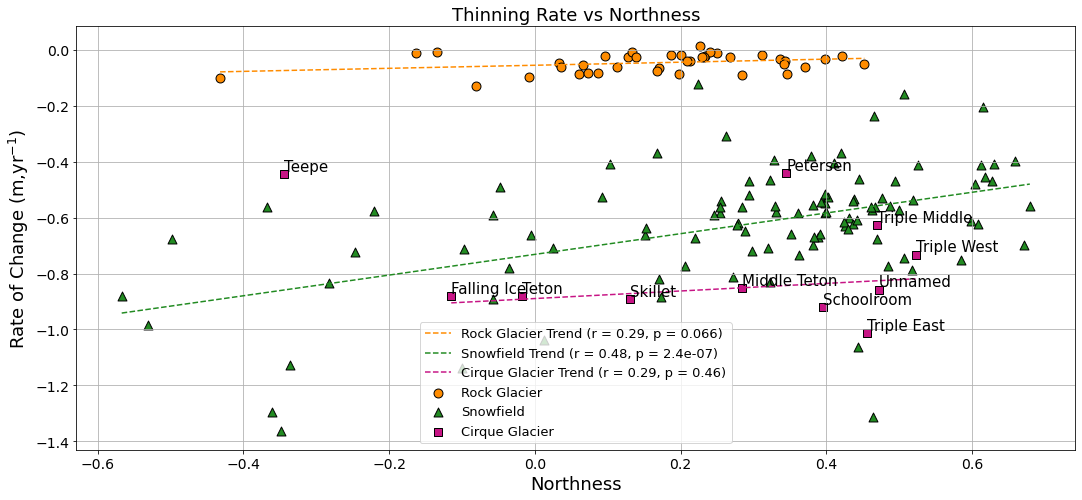

<Figure size 432x288 with 0 Axes>

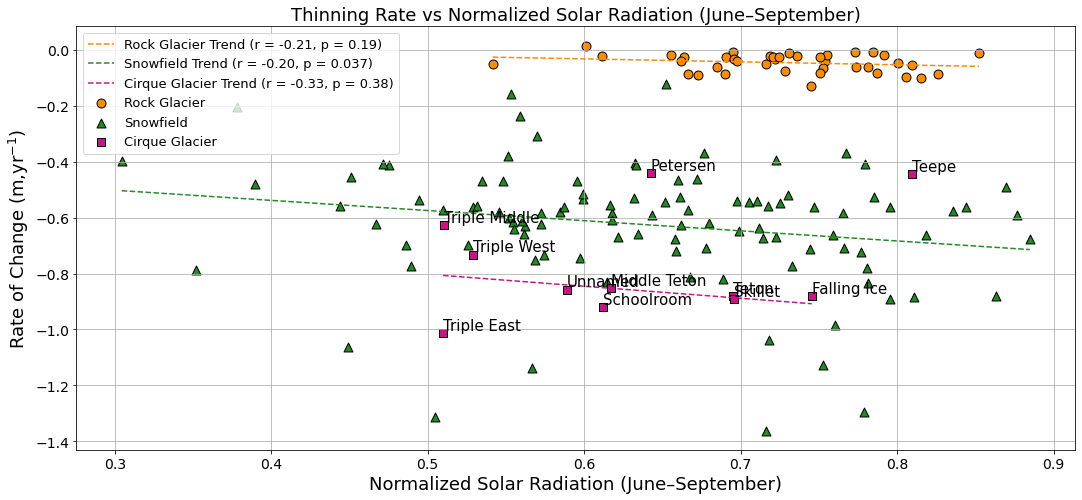

<Figure size 432x288 with 0 Axes>

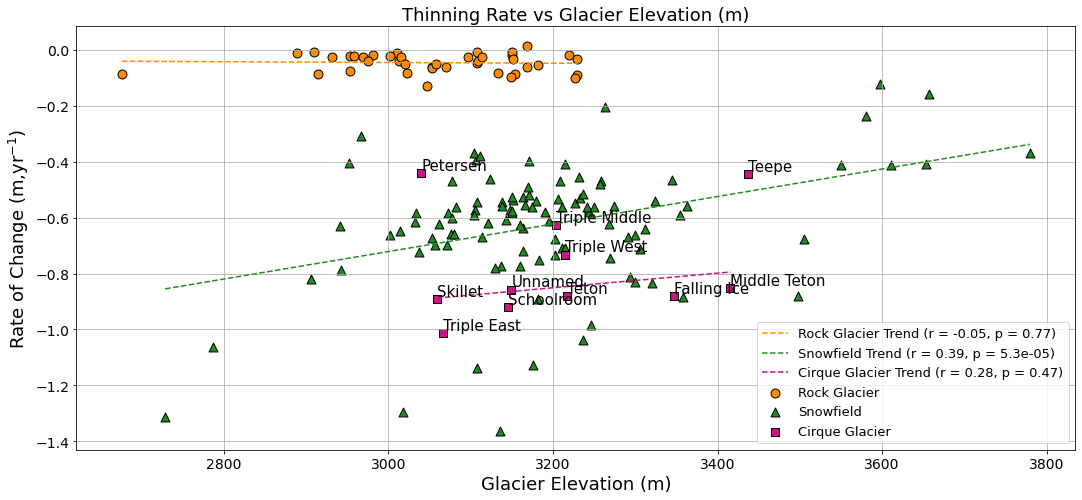

<Figure size 432x288 with 0 Axes>

In [6]:
# === Load CSVs ===
glacier_df = pd.read_csv("glacier_medians.csv")
rock_df    = pd.read_csv("rock_glacier_medians.csv")
snow_df    = pd.read_csv("snowfield_medians.csv")

# === Add glacier names by ID ===
glacier_names = {
    0: "Teton", 1: "Teepe", 2: "Triple West", 3: "Falling Ice",
    4: "Triple Middle", 5: "Triple East", 6: "Skillet",
    7: "Unnamed", 8: "Petersen", 9: "Schoolroom", 10: "Middle Teton"
}
glacier_df["name"] = glacier_df["id"].map(glacier_names)

# === Flag Teepe (1) & Petersen (8) — DON'T DROP THEM ===
exclude_ids = [1, 8]
glacier_df["exclude"] = glacier_df["id"].isin(exclude_ids).astype(bool)

# === Assign landform type ===
glacier_df["type"] = "Cirque Glacier"
rock_df["type"]    = "Rock Glacier"
snow_df["type"]    = "Snowfield"

# === Combine all ===
df = pd.concat([glacier_df, rock_df, snow_df], ignore_index=True)



# === Style maps ===
color_map  = {"Cirque Glacier": "mediumvioletred", "Rock Glacier": "darkorange", "Snowfield": "forestgreen"}
marker_map = {"Cirque Glacier": "s",        "Rock Glacier": "o",       "Snowfield": "^"}

# === Variables to plot ===
x_vars  = ["median_northness", "median_solar", "median_elevation"]
x_labels = [
    "Northness",
    "Normalized Solar Radiation (June–September)",
    "Glacier Elevation (m)"
]

# === Plotting ===
for x_var, xlabel in zip(x_vars, x_labels):
    plt.figure(figsize=(15, 7))

    # ock Glacier + Snowfield: plot + trend 
    for landform in ["Rock Glacier", "Snowfield"]:
        sub = df[df["type"] == landform]
        x, y = sub[x_var], sub["median_dhdt"]

        plt.scatter(
            x, y,
            label=landform,
            color=color_map[landform],
            marker=marker_map[landform],
            edgecolor="black",
            s=80
        )

        m = x.notna() & y.notna()
        if m.sum() > 2:
            slope, intercept, r, p, _ = linregress(x[m], y[m])
            x_line = np.linspace(x[m].min(), x[m].max(), 200)
            plt.plot(
                x_line, slope * x_line + intercept,
                linestyle="--",
                color=color_map[landform],
                label=f"{landform} Trend (r = {r:.2f}, p = {p:.2g})"
            )

    # Cirque Glacier — split into core (used in trend) vs excluded (just points) (petersen and teepe excluded frgmented ice)
    cirque_all  = df[df["type"] == "Cirque Glacier"].copy()
    mask_excl   = cirque_all["exclude"].astype(bool) if "exclude" in cirque_all.columns else False
    cirque_core = cirque_all[~mask_excl]
    cirque_excl = cirque_all[mask_excl]

    #  plot Cirque CORE points
    plt.scatter(
        cirque_core[x_var], cirque_core["median_dhdt"],
        label="Cirque Glacier",
        color=color_map["Cirque Glacier"],
        marker=marker_map["Cirque Glacier"],
        edgecolor="black",
        s=80
    )

    # trend ONLY on Cirque CORE
    m_core = cirque_core[x_var].notna() & cirque_core["median_dhdt"].notna()
    if m_core.sum() > 2:
        slope, intercept, r, p, _ = linregress(
            cirque_core.loc[m_core, x_var], cirque_core.loc[m_core, "median_dhdt"]
        )
        x_line = np.linspace(cirque_core.loc[m_core, x_var].min(),
                             cirque_core.loc[m_core, x_var].max(), 200)
        plt.plot(
            x_line, slope * x_line + intercept, "--",
            color=color_map["Cirque Glacier"],
            label=f"Cirque Glacier Trend (r = {r:.2f}, p = {p:.2g})"
        )

    # plot EXCLUDED Cirque points (same symbology), NO trend contribution (teepe and petersen glacier fragmented ice)
    if not cirque_excl.empty:
        plt.scatter(
            cirque_excl[x_var], cirque_excl["median_dhdt"],
            color=color_map["Cirque Glacier"],
            marker=marker_map["Cirque Glacier"],
            edgecolor="black",
            s=80,

        )

    # labels for ALL Cirque points (core + excluded)
    for _, row in cirque_all.dropna(subset=[x_var, "median_dhdt"]).iterrows():
        if row.get("name"):
            plt.text(
                row[x_var], row["median_dhdt"], row["name"],
                fontsize=15, ha="left", va="bottom", color="black"
            )

    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(r"Rate of Change (m,yr$^{-1}$)", fontsize=18)
    plt.title(f"Thinning Rate vs {xlabel}", fontsize=18)
    plt.grid(True)
    plt.legend(title="", fontsize=13)
    plt.tight_layout()
    plt.yticks(fontsize=14); plt.xticks(fontsize=14)
    plt.show()
    plt.savefig(f"thinning_vs_{x_var}.jpg", dpi=300, bbox_inches="tight")
